<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch5-MonteCarloMethods/RaceTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
from tqdm import tqdm
np.random.seed(0)

### Initialize Tracks

In [2]:
def get_circuits():
  nRows_1 = 32
  nCols_1 = 17
  map_1 = np.zeros((nRows_1,nCols_1))
  map_1[-1,3:9] = 1
  map_1[0:6,-1] = 2
  map_1[-3:,:3] = 3
  map_1[-10:-3:,:2] = 3
  map_1[-18:-10:,:1] = 3
  map_1[0,:3] = 3
  map_1[1:3,:2] = 3
  map_1[3,:1] = 3
  map_1[7:,9:] = 3
  map_1[6,10:] = 3

  nRows_2 = 30
  nCols_2 = 32
  map_2 = np.zeros((nRows_2,nCols_2))
  map_2[-1,:23] = 1
  map_2[0:9,-1] = 2
  map_2[-17:,23:] = 3
  map_2[-18:,24:] = 3
  map_2[-19:,26:] = 3
  map_2[-20:,27:] = 3
  map_2[-21:,30:] = 3
  map_2[0,:16] = 3
  map_2[[1,8],:13] = 3
  map_2[[2,7],:12] = 3
  map_2[3:7,:11] = 3
  map_2[9:14,:14] = 3
  c = 1
  for i in range(14,nRows_2-2):
    map_2[i,:14-c] = 3
    c += 1
  return map_1,map_2

def plot_circuit(fig,map,num):
  nRows,nCols = map.shape
  # create discrete colormap
  #cmap = colors.ListedColormap(['red', 'blue'])
  cmap = colors.ListedColormap(['white','red','green','black'])
  bounds = [0,0.1,3]
  norm = colors.BoundaryNorm(bounds, cmap.N)
  ax = fig.add_subplot(1,2,num)
  ax.imshow(map, cmap=cmap)#, norm=norm)

  ### draw gridlines
  # ax = plt.gca();
  ax.set_xticks(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticks(np.arange(-0.5, nRows+0.5, 1));
  ax.set_xticklabels(np.arange(-0.5, nCols+0.5, 1));
  ax.set_yticklabels(np.arange(-0.5, nRows+0.5, 1));
  ax.grid(color='k', linestyle='-', linewidth=1)

  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')

### Visualize Race Tracks

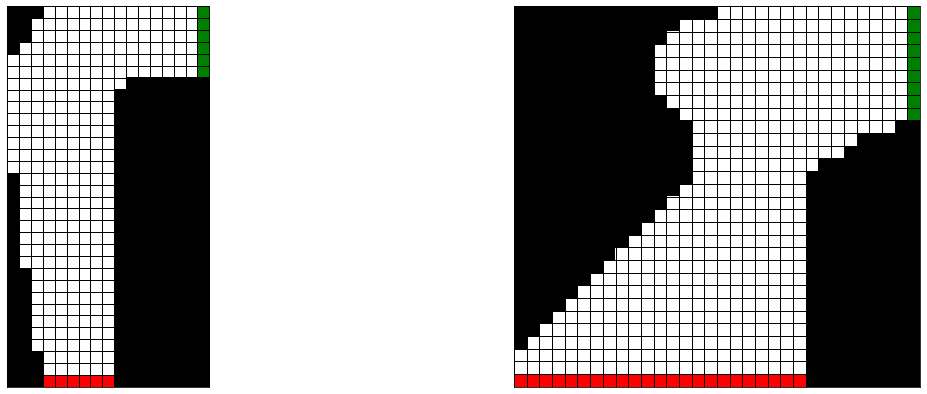

In [3]:
map_1,map_2 = get_circuits()
fig = plt.figure(figsize=(20,7))#20,7)
plot_circuit(fig,map_1,1)
plot_circuit(fig,map_2,2)

In [16]:
max_velocity = 5
actions = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,0],[0,1],[1,-1],[1,0],[1,1]])
gamma = 1.0

def init_state(map):
  find_start_line = np.where(map == 1)
  start_line = np.array(list(zip(find_start_line[0],find_start_line[1])))
  choice = np.random.choice(range(start_line.shape[0]))
  init = [start_line[choice,0],start_line[choice,1],0,0]
  ## print('Start Line Coordinates:',start_line)
  ## print(choice,init)
  return init

def check_termination(map,curr_state):
  finish_line = np.where(map == 2)
  return curr_state[1] > finish_line[1][0] and curr_state[0] >= np.min(finish_line[0]) and curr_state[0] <= np.max(finish_line[0])

def check_OutOfBounds(map,curr_state):
  if min(curr_state[0],curr_state[1]) < 0:
    return True
  elif check_termination(map,curr_state):
    return False
  elif curr_state[1] > map.shape[1] or curr_state[0] >= map.shape[0]:
    return True
  return map[curr_state[0],curr_state[1]] == 3

def behavior_policy():
  act_idx = np.random.choice(range(actions.shape[0]))
  return actions[act_idx,:]

def play(map,init):
  curr_state = np.copy(init)
  reward = 0
  traj = [curr_state]
  while not check_termination(map,curr_state):
    reward -= 1
    act = behavior_policy()
    new_vel = [curr_state[2]+act[0],curr_state[3]+act[1]]
    next_state = [curr_state[0]+new_vel[0],curr_state[1]+new_vel[1]] + new_vel
    if check_OutOfBounds(map,next_state):
      curr_state = init_state(map)
      traj = [curr_state]
      continue
    curr_state = next_state
    traj += [curr_state]
  return reward,traj

Reward = : -35042
[1, 18, -2, 5] True
(array([0, 1, 2, 3, 4, 5]), array([16, 16, 16, 16, 16, 16]))
True
True



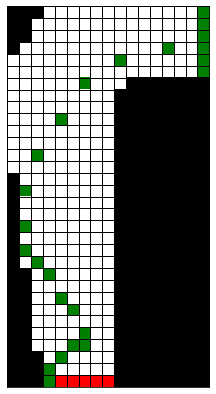

In [27]:
init = init_state(map_1)
reward,traj = play(map_1,init)
print('Reward = :',reward)
final_map = np.copy(map_1)
for t in traj:
  final_map[min(t[0],map_1.shape[0]-1),min(t[1],map_1.shape[1]-1)] = 1.5
fig = plt.figure(figsize=(20,7))#20,7)
plot_circuit(fig,final_map,1)
print(traj[-1],check_termination(map_1,traj[-1]))

finish_line = np.where(map_1 == 2)
print(finish_line)
print(traj[-1][1] > finish_line[1][0])
print(traj[-1][0] >= np.min(finish_line[0]) and traj[-1][0] <= np.max(finish_line[0]))
print()